## Postprocessing techniques 
- all the 3d points are in pixel units, convert them to meters
- **Pre-filter detections**: Keep only high-confidence YOLO detections.
- **Temporal filtering**: Remove sudden 2D/3D jumps across frames.
- **Spatial filtering**: Use RANSAC or median filtering on triangulated 3D points to reject outliers.

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import json
import shutil
import sys
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def find_project_root(marker=".gitignore"):
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}")
    
root = find_project_root()

In [2]:
triangulation_results_path = f"{root}/data/stereo_A_detections_triangulated.csv"
triangulation_results = pd.read_csv(triangulation_results_path)
triangulation_results.sort_values(by='frame_no', inplace=True)
triangulation_results.head()

,Unnamed: 0,frame_no,A1_x,A1_y,A1_confidence,A1_method,A2_x,A2_y,A2_confidence,A2_method,position_3d_pixels,A1_reprojected_point,A1_error_cm,A2_reprojected_point,A2_error_cm,anomaly_detected
0,0,1021,795,468,0.808076,YOLO,1023,452,0.502068,YOLO,"[-1864.3065328634257, -484.0727254308621, 7931...","[1587.2223263659757, 934.4073687215065]",0.834419,"[2045.9062117271465, 905.6761288547647]",0.732834,False
1,1,1022,813,462,0.400000,LK,1008,447,0.400000,LK,"[-1665.6171897454321, -537.822965840526, 7813....","[1623.8199721500437, 922.0524018239382]",0.960843,"[2015.9590601325751, 895.9249718245585]",0.844847,False
2,2,1023,832,458,0.823879,YOLO,993,443,0.300000,LK,"[-1464.3183770688977, -574.2115262906742, 7703...","[1662.3921371759302, 913.0021167199477]",1.431932,"[1986.0531043037106, 888.8069618437115]",1.262187,False
3,5,1026,868,449,0.300000,LK,946,432,0.659355,YOLO,"[-1069.4450420583794, -656.4915356698945, 7310...","[1735.6096196304525, 888.8165415962574]",4.159512,"[1892.6242759283302, 871.9724156480165]",3.573039,False
4,6,1027,896,442,0.636824,BG,949,433,0.772284,BG,"[-838.3984785193841, -685.1457799815197, 7423....","[1791.3741484483517, 884.8719008599403]",0.399873,"[1897.9542660379745, 865.5011696532832]",0.359587,False


In [3]:
first = triangulation_results.iloc[0]
first.to_dict()

{'Unnamed: 0': 0,
 'frame_no': 1021,
 'A1_x': 795,
 'A1_y': 468,
 'A1_confidence': 0.8080763816833496,
 'A1_method': 'YOLO',
 'A2_x': 1023,
 'A2_y': 452,
 'A2_confidence': 0.502068281173706,
 'A2_method': 'YOLO',
 'position_3d_pixels': '[-1864.3065328634257, -484.0727254308621, 7931.310431658029]',
 'A1_reprojected_point': '[1587.2223263659757, 934.4073687215065]',
 'A1_error_cm': 0.8344187257267268,
 'A2_reprojected_point': '[2045.9062117271465, 905.6761288547647]',
 'A2_error_cm': 0.7328338529303627,
 'anomaly_detected': False}

## Plot 2D reprojected points

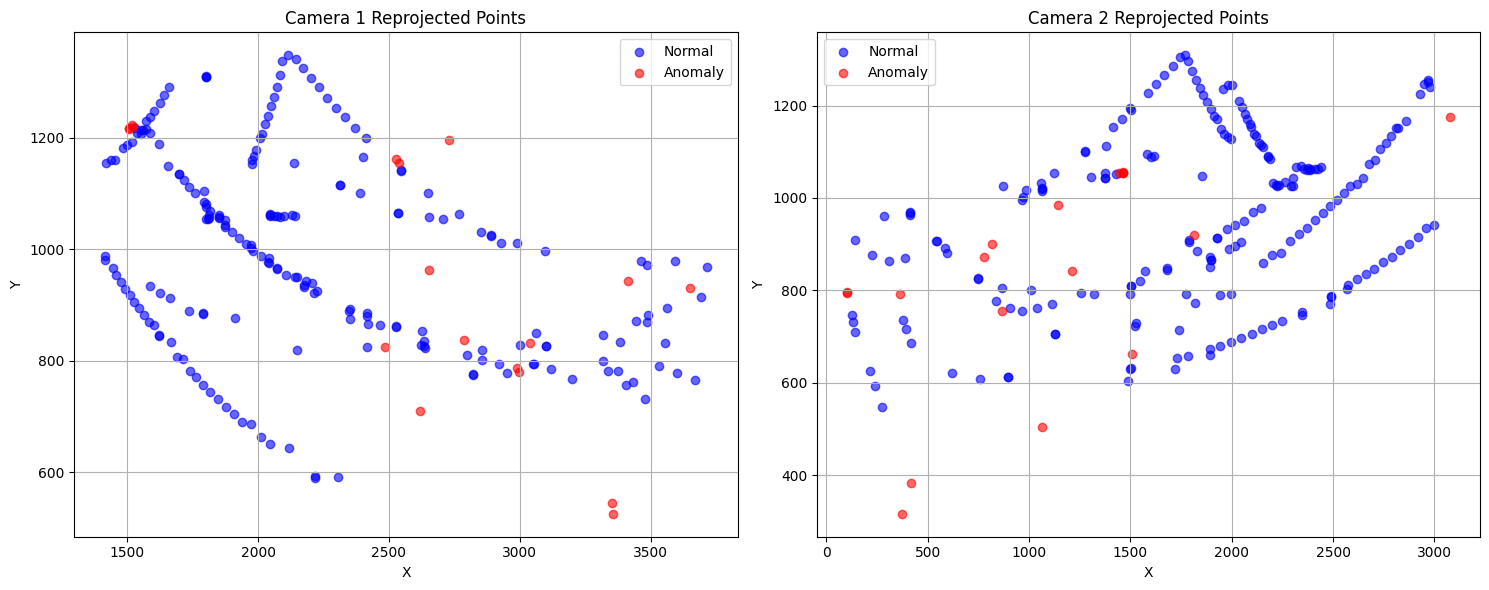

In [4]:
def plot_2d_reprojected_points(triangulation_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Extract points
    points_2d_1 = np.array([eval(p) for p in triangulation_results['A1_reprojected_point']])
    points_2d_2 = np.array([eval(p) for p in triangulation_results['A2_reprojected_point']])
    anomaly_mask = triangulation_results['anomaly_detected']
    
    # Plot for camera 1
    ax1.scatter(points_2d_1[~anomaly_mask, 0], points_2d_1[~anomaly_mask, 1], c='blue', alpha=0.6, label='Normal')
    ax1.scatter(points_2d_1[anomaly_mask, 0], points_2d_1[anomaly_mask, 1], c='red', alpha=0.6, label='Anomaly')
    ax1.set_title('Camera 1 Reprojected Points')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.legend()
    ax1.grid(True)
    
    # Plot for camera 2
    ax2.scatter(points_2d_2[~anomaly_mask, 0], points_2d_2[~anomaly_mask, 1], c='blue', alpha=0.6, label='Normal')
    ax2.scatter(points_2d_2[anomaly_mask, 0], points_2d_2[anomaly_mask, 1], c='red', alpha=0.6, label='Anomaly')
    ax2.set_title('Camera 2 Reprojected Points')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
plot_2d_reprojected_points(triangulation_results)

## Plot 2D original vs reprojected

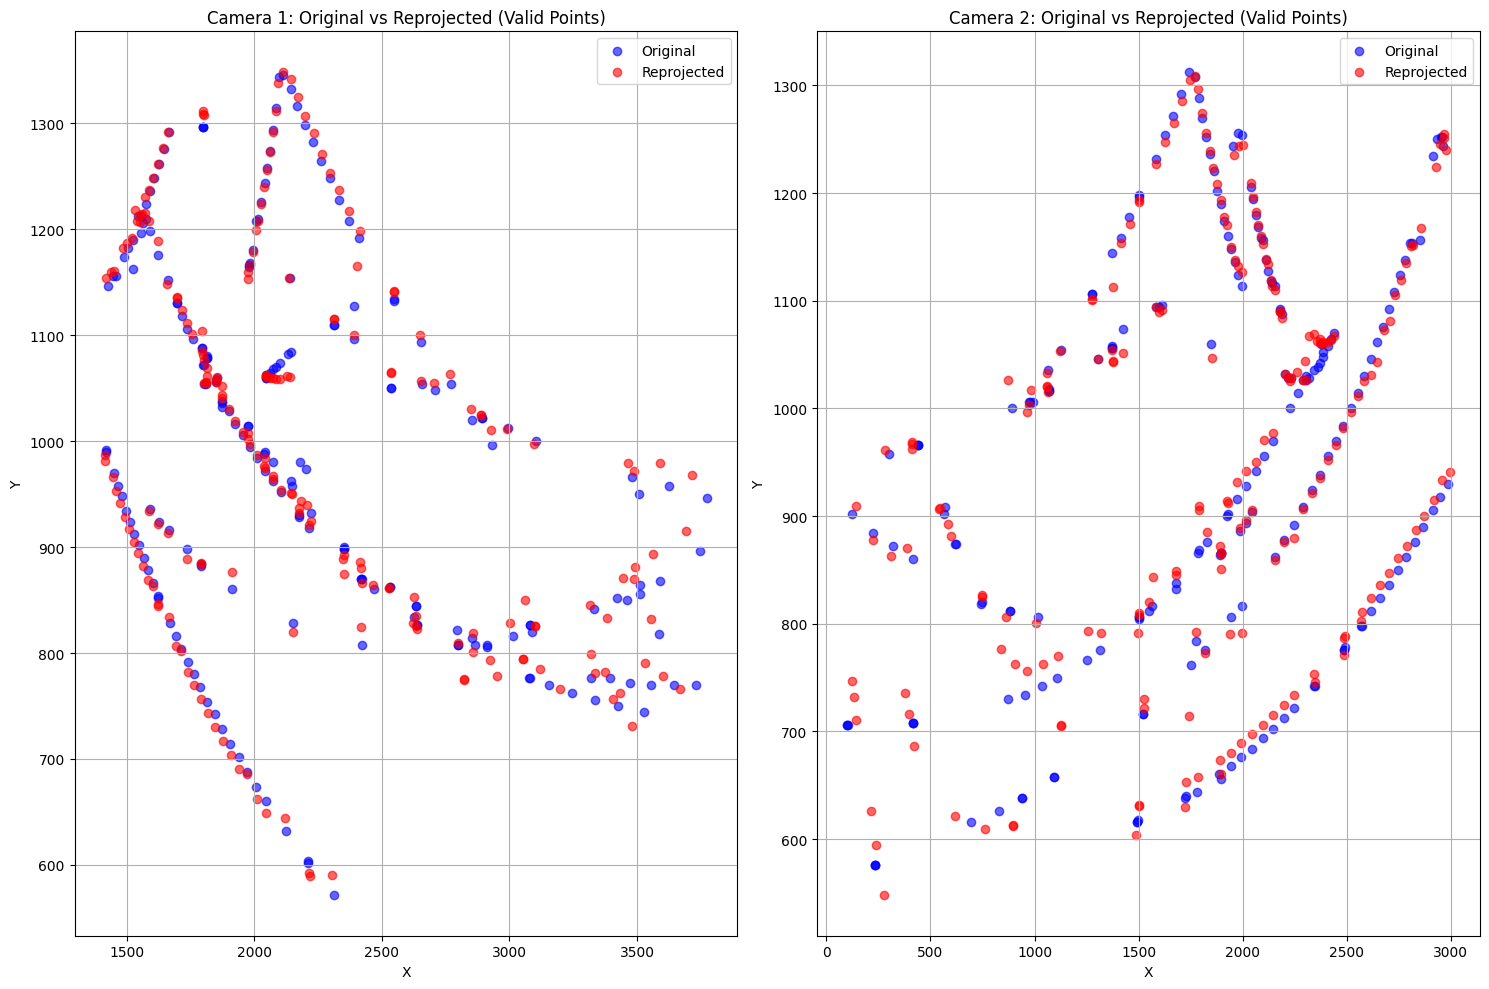

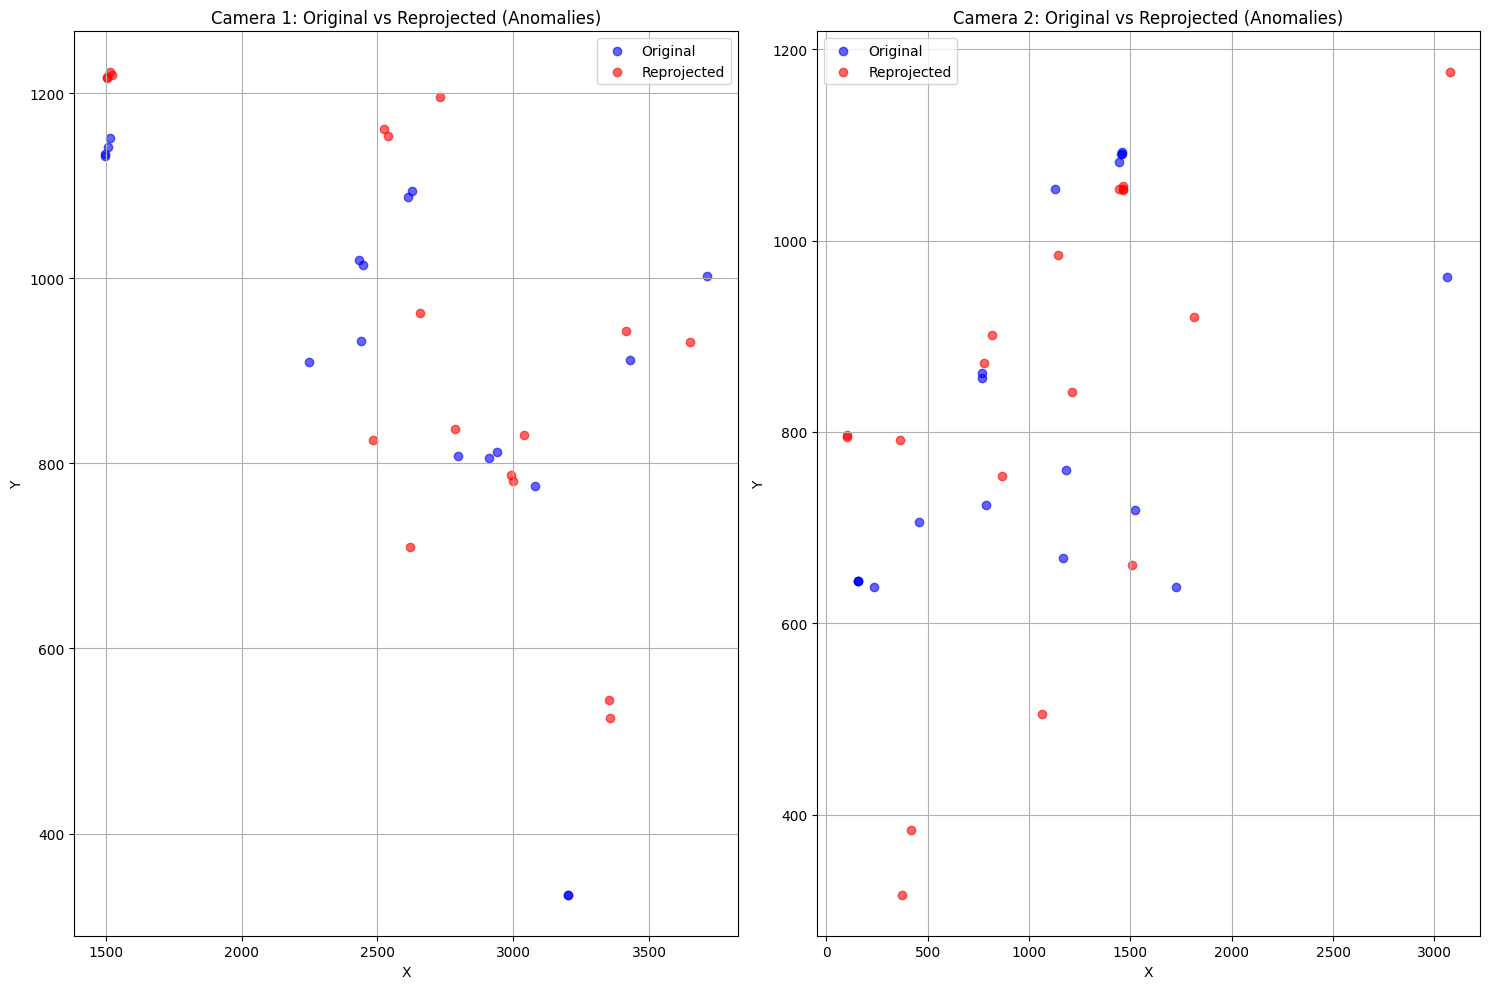

In [5]:
def plot_valid_vs_original(triangulation_results, scale_factor=2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

    # Extract points
    original_2d_1 = np.array([[row['A1_x'] * scale_factor, row['A1_y'] * scale_factor] for _, row in triangulation_results.iterrows()])
    points_2d_1 = np.array([eval(p) for p in triangulation_results['A1_reprojected_point']])
    original_2d_2 = np.array([[row['A2_x'] * scale_factor, row['A2_y'] * scale_factor] for _, row in triangulation_results.iterrows()])
    points_2d_2 = np.array([eval(p) for p in triangulation_results['A2_reprojected_point']])
    anomaly_mask = triangulation_results['anomaly_detected']
    
    
    # Plot for camera 1
    ax1.scatter(original_2d_1[~anomaly_mask, 0], original_2d_1[~anomaly_mask, 1], c='blue', alpha=0.6, label='Original')
    ax1.scatter(points_2d_1[~anomaly_mask, 0], points_2d_1[~anomaly_mask, 1], c='red', alpha=0.6, label='Reprojected')
    ax1.set_title('Camera 1: Original vs Reprojected (Valid Points)')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.legend()
    ax1.grid(True)
    
    # Plot for camera 2
    ax2.scatter(original_2d_2[~anomaly_mask, 0], original_2d_2[~anomaly_mask, 1], c='blue', alpha=0.6, label='Original')
    ax2.scatter(points_2d_2[~anomaly_mask, 0], points_2d_2[~anomaly_mask, 1], c='red', alpha=0.6, label='Reprojected')
    ax2.set_title('Camera 2: Original vs Reprojected (Valid Points)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
  

def plot_anomaly_vs_original(triangulation_results, scale_factor=2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
    
    # Extract points
    original_2d_1 = np.array([[row['A1_x'] * scale_factor, row['A1_y'] * scale_factor] for _, row in triangulation_results.iterrows()])
    points_2d_1 = np.array([eval(p) for p in triangulation_results['A1_reprojected_point']])
    original_2d_2 = np.array([[row['A2_x'] * scale_factor, row['A2_y'] * scale_factor] for _, row in triangulation_results.iterrows()])
    points_2d_2 = np.array([eval(p) for p in triangulation_results['A2_reprojected_point']])
    anomaly_mask = triangulation_results['anomaly_detected']
    
    
    # Plot for camera 1
    ax1.scatter(original_2d_1[anomaly_mask, 0], original_2d_1[anomaly_mask, 1], c='blue', alpha=0.6, label='Original')
    ax1.scatter(points_2d_1[anomaly_mask, 0], points_2d_1[anomaly_mask, 1], c='red', alpha=0.6, label='Reprojected')
    ax1.set_title('Camera 1: Original vs Reprojected (Anomalies)')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.legend()
    ax1.grid(True)
    
    # Plot for camera 2
    ax2.scatter(original_2d_2[anomaly_mask, 0], original_2d_2[anomaly_mask, 1], c='blue', alpha=0.6, label='Original')
    ax2.scatter(points_2d_2[anomaly_mask, 0], points_2d_2[anomaly_mask, 1], c='red', alpha=0.6, label='Reprojected')
    ax2.set_title('Camera 2: Original vs Reprojected (Anomalies)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
  
plot_valid_vs_original(triangulation_results)
plot_anomaly_vs_original(triangulation_results)

## Plot 3D points and anomalies in different color

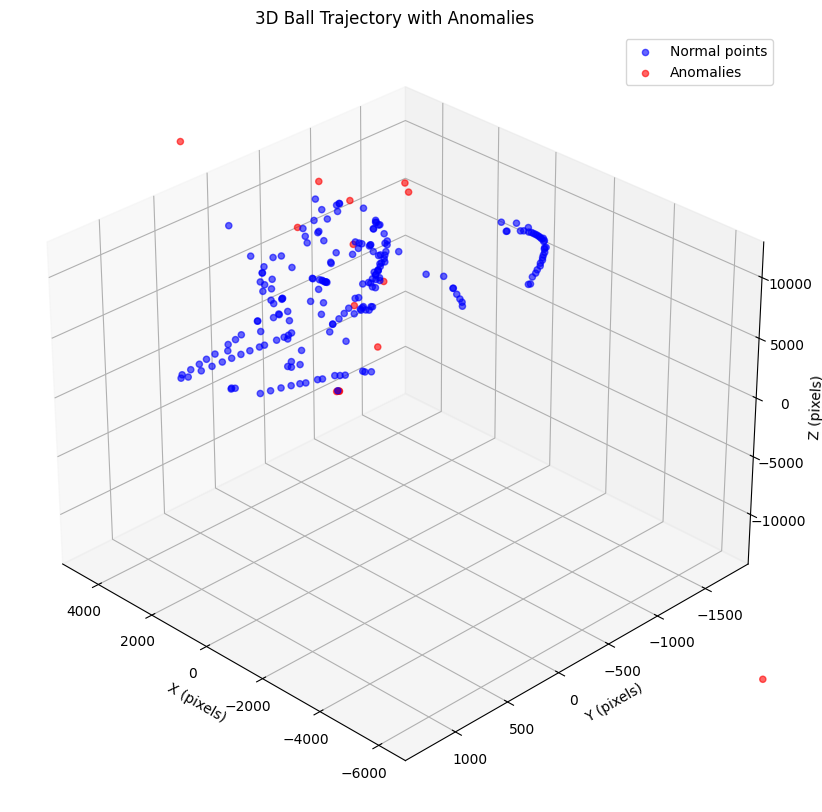

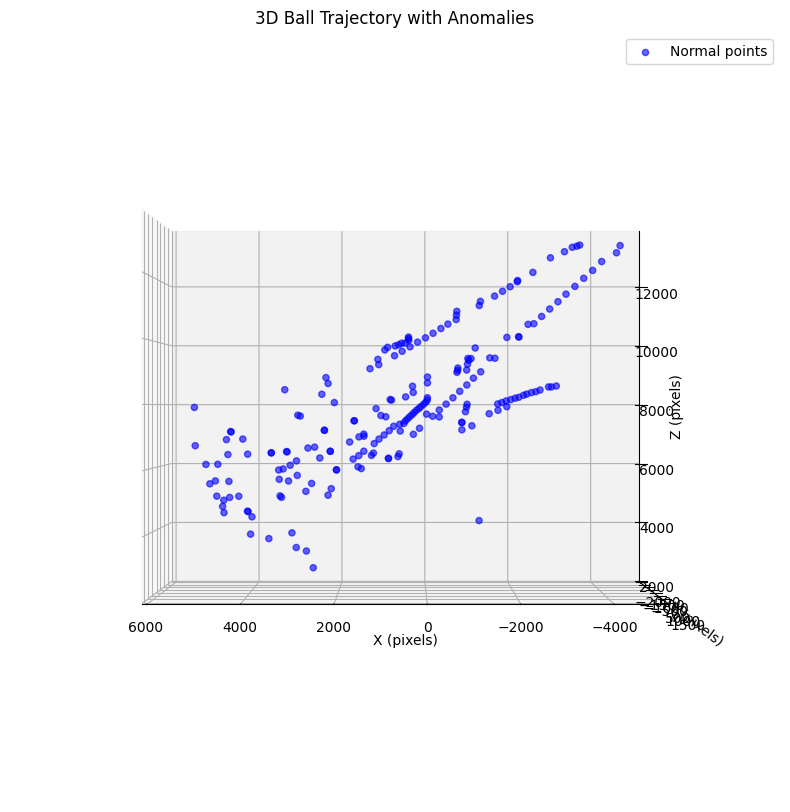

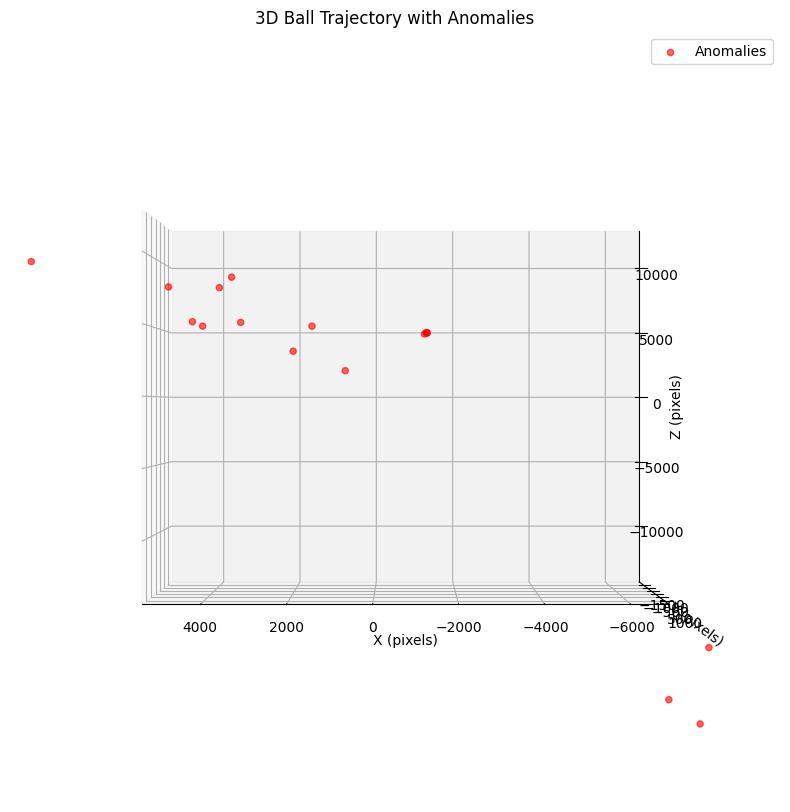

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_points_with_anomalies(triangulation_results):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Extract 3D points and separate normal points from anomalies
    points_3d = np.array([eval(p) for p in triangulation_results['position_3d_pixels']])
    normal_mask = ~triangulation_results['anomaly_detected']
    anomaly_mask = triangulation_results['anomaly_detected']

    # Plot normal points in blue
    ax.scatter(points_3d[normal_mask, 0],
               points_3d[normal_mask, 1],
               points_3d[normal_mask, 2],
               c='blue', label='Normal points', alpha=0.6)

    # Plot anomalies in red
    ax.scatter(points_3d[anomaly_mask, 0],
               points_3d[anomaly_mask, 1],
               points_3d[anomaly_mask, 2],
               c='red', label='Anomalies', alpha=0.6)

    # Customize the plot
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.set_zlabel('Z (pixels)')
    ax.set_title('3D Ball Trajectory with Anomalies')
    ax.legend()
    ax.grid(True)
    # ax.view_init(elev=0, azim=90)    # side view
    # ax.view_init(elev=90, azim=0)    # top view
    ax.view_init(elev=30, azim=135)  # diagonal view
    ax.dist = 2  # Adjust zoom level (lower number = more zoom)
    percentile = 99  # adjust between 90-99 to include more/less points
    ax.set_xlim(np.percentile(points_3d[:, 0], [100-percentile, percentile]))
    ax.set_ylim(np.percentile(points_3d[:, 1], [100-percentile, percentile]))
    ax.set_zlim(np.percentile(points_3d[:, 2], [100-percentile, percentile]))
    plt.show()


def plot_3d_filtered_points(triangulation_results):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Extract 3D points and separate normal points from anomalies
    points_3d = np.array([eval(p) for p in triangulation_results['position_3d_pixels']])
    normal_mask = ~triangulation_results['anomaly_detected']

    # Plot normal points in blue
    ax.scatter(points_3d[normal_mask, 0],
               points_3d[normal_mask, 1],
               points_3d[normal_mask, 2],
               c='blue', label='Normal points', alpha=0.6)

    # Customize the plot
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.set_zlabel('Z (pixels)')
    ax.set_title('3D Ball Trajectory with Anomalies')
    ax.legend()
    ax.grid(True)
    ax.view_init(elev=0, azim=90)    # side view
    # ax.view_init(elev=90, azim=0)    # top view
    # ax.view_init(elev=30, azim=135)  # diagonal view
    ax.dist = 2  # Adjust zoom level (lower number = more zoom)
    plt.show()


def plot_3d_anomalies_points(triangulation_results):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Extract 3D points and separate normal points from anomalies
    points_3d = np.array([eval(p) for p in triangulation_results['position_3d_pixels']])
    anomaly_mask = triangulation_results['anomaly_detected']

    # Plot anomalies in red
    ax.scatter(points_3d[anomaly_mask, 0],
               points_3d[anomaly_mask, 1],
               points_3d[anomaly_mask, 2],
               c='red', label='Anomalies', alpha=0.6)

    # Customize the plot
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.set_zlabel('Z (pixels)')
    ax.set_title('3D Ball Trajectory with Anomalies')
    ax.legend()
    ax.grid(True)
    ax.view_init(elev=0, azim=90)    # side view
    # ax.view_init(elev=90, azim=0)    # top view
    # ax.view_init(elev=30, azim=135)  # diagonal view
    ax.dist = 2  # Adjust zoom level (lower number = more zoom)
    percentile = 99  # adjust between 90-99 to include more/less points
    ax.set_xlim(np.percentile(points_3d[:, 0], [100-percentile, percentile]))
    ax.set_ylim(np.percentile(points_3d[:, 1], [100-percentile, percentile]))
    ax.set_zlim(np.percentile(points_3d[:, 2], [100-percentile, percentile]))
    plt.show()


plot_3d_points_with_anomalies(triangulation_results)
plot_3d_filtered_points(triangulation_results)
plot_3d_anomalies_points(triangulation_results)

## Jitter plots 
Jitter -> small, rapid, unwanted changes in values across frames

Plot 2D points (A1_x, A1_y, A2_x, A2_y) over time.
- If they jump a lot → YOLO jitter.

Plot 3D Z over time.
- If 2D is smooth but Z is noisy → likely triangulation / calibration issue.

Compare high-confidence vs. low-confidence points.
- If jitter increases when confidence drops → YOLO is the issue.

In [7]:
tr = triangulation_results.iloc[:15]
tr.head(15)

,Unnamed: 0,frame_no,A1_x,A1_y,A1_confidence,A1_method,A2_x,A2_y,A2_confidence,A2_method,position_3d_pixels,A1_reprojected_point,A1_error_cm,A2_reprojected_point,A2_error_cm,anomaly_detected
0,0,1021,795,468,0.808076,YOLO,1023,452,0.502068,YOLO,"[-1864.3065328634257, -484.0727254308621, 7931...","[1587.2223263659757, 934.4073687215065]",0.834419,"[2045.9062117271465, 905.6761288547647]",0.732834,False
1,1,1022,813,462,0.400000,LK,1008,447,0.400000,LK,"[-1665.6171897454321, -537.822965840526, 7813....","[1623.8199721500437, 922.0524018239382]",0.960843,"[2015.9590601325751, 895.9249718245585]",0.844847,False
2,2,1023,832,458,0.823879,YOLO,993,443,0.300000,LK,"[-1464.3183770688977, -574.2115262906742, 7703...","[1662.3921371759302, 913.0021167199477]",1.431932,"[1986.0531043037106, 888.8069618437115]",1.262187,False
3,5,1026,868,449,0.300000,LK,946,432,0.659355,YOLO,"[-1069.4450420583794, -656.4915356698945, 7310...","[1735.6096196304525, 888.8165415962574]",4.159512,"[1892.6242759283302, 871.9724156480165]",3.573039,False
4,6,1027,896,442,0.636824,BG,949,433,0.772284,BG,"[-838.3984785193841, -685.1457799815197, 7423....","[1791.3741484483517, 884.8719008599403]",0.399873,"[1897.9542660379745, 865.5011696532832]",0.359587,False
5,7,1028,896,441,0.400000,LK,948,433,0.400000,LK,"[-837.428361908083, -689.3523644671777, 7412.5...","[1791.315851184213, 883.7580637057471]",0.806991,"[1895.897095914235, 864.7244091095876]",0.724491,False
6,8,1029,956,430,0.705377,BG,948,433,0.300000,LK,"[-315.32584154499057, -742.4305386815527, 7596...","[1910.7920485553004, 876.2617371374624]",7.592332,"[1894.8271604729957, 850.7492042140683]",7.480502,False
7,15,1036,1075,414,0.300000,LK,774,406,0.620843,YOLO,"[642.2492138329906, -840.4602322437862, 6297.7...","[2150.671703970166, 819.6539882065044]",3.609292,"[1549.560601385053, 820.5944163202488]",3.118727,False
8,18,1039,1211,404,0.438586,YOLO,751,403,0.300000,LK,"[1767.9983771803356, -884.5334150052416, 6772....","[2416.607324836992, 824.1663581070413]",6.179456,"[1499.207682882974, 791.2391676295506]",6.873534,False
9,25,1046,1433,404,0.797257,YOLO,509,403,0.387809,YOLO,"[2979.8563085973683, -761.5614104184359, 5685....","[2856.4036704987125, 818.8665707636904]",2.935153,"[1007.8320580875156, 800.34438508659]",3.096985,False


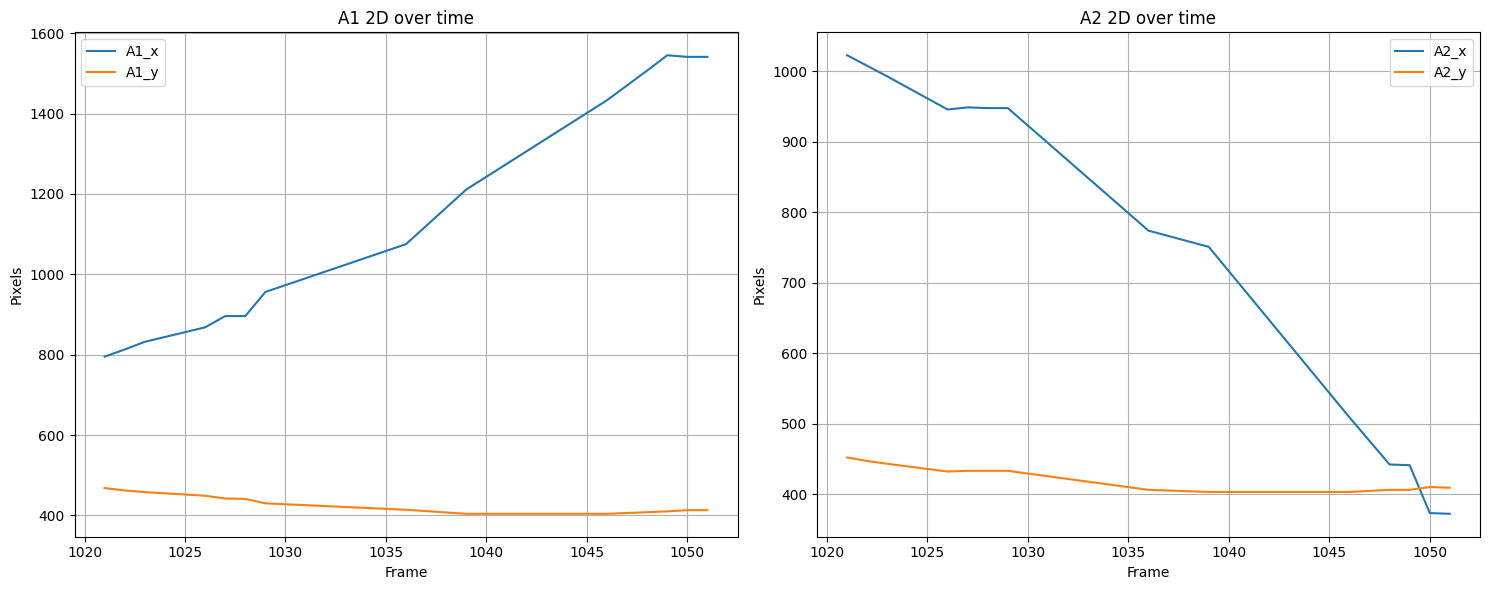

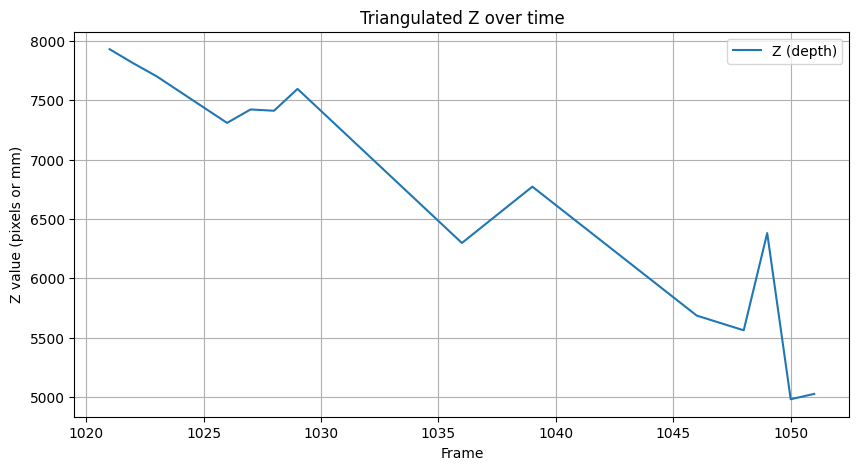

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_2d_over_time(triangulation_results):
    triangulation_results = triangulation_results[~triangulation_results['anomaly_detected']]
    frames = triangulation_results['frame_no']
    A1_x = triangulation_results['A1_x']
    A1_y = triangulation_results['A1_y']
    A2_x = triangulation_results['A2_x']
    A2_y = triangulation_results['A2_y']

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(frames, A1_x, label='A1_x')
    plt.plot(frames, A1_y, label='A1_y')
    plt.title('A1 2D over time')
    plt.xlabel('Frame')
    plt.ylabel('Pixels')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(frames, A2_x, label='A2_x')
    plt.plot(frames, A2_y, label='A2_y')
    plt.title('A2 2D over time')
    plt.xlabel('Frame')
    plt.ylabel('Pixels')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_3d_z_over_time(triangulation_results):
    triangulation_results = triangulation_results[~triangulation_results['anomaly_detected']]
    frames = triangulation_results['frame_no']
    z_values = [eval(pos)[2] for pos in triangulation_results['position_3d_pixels']]

    plt.figure(figsize=(10, 5))
    plt.plot(frames, z_values, label='Z (depth)')
    plt.title('Triangulated Z over time')
    plt.xlabel('Frame')
    plt.ylabel('Z value (pixels or mm)')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_2d_over_time(tr)
plot_3d_z_over_time(tr)

# Temporal filtering
- smooths data over time 
- reduces jitter -> small, rapid, unwanted changes in values across frames

## Savitzky-Golay filter 
1. Takes a sliding window of points (window_length parameter)
2. Fits a polynomial (polyorder parameter) to those points
3. Replaces the center point with the polynomial's value
4. Moves window forward and repeats

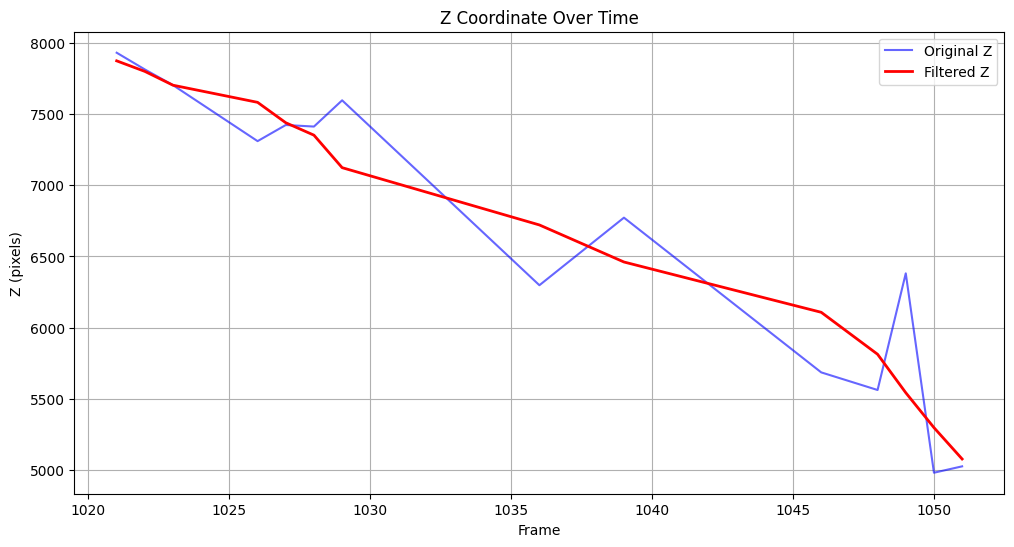

In [9]:
import ast
from scipy.signal import savgol_filter

tr = triangulation_results.iloc[:15]
tr = tr[~tr['anomaly_detected']]

# Extract Z coordinates from position_3d_pixels
z_coords = np.array([ast.literal_eval(pos)[2] for pos in tr['position_3d_pixels']])
frames = tr['frame_no']

# Apply Savitzky-Golay filter
# Adjust window_length (must be odd) and polyorder for desired smoothing
# longer length = more smoothing
# more polyorder = more complex polynomial
z_filtered = savgol_filter(z_coords, window_length=9, polyorder=2)

# Plot original vs filtered
plt.figure(figsize=(12, 6))
plt.plot(frames, z_coords, 'b-', label='Original Z', alpha=0.6)
plt.plot(frames, z_filtered, 'r-', label='Filtered Z', linewidth=2)
plt.title('Z Coordinate Over Time')
plt.xlabel('Frame')
plt.ylabel('Z (pixels)')
plt.legend()
plt.grid(True)
plt.show()

def apply_savgol_filter(triangulation_results):
  # Extract Z coordinates from position_3d_pixels
  z_coords = np.array([ast.literal_eval(pos)[2] for pos in triangulation_results['position_3d_pixels']])
  frames = triangulation_results['frame_no']

  # Apply Savitzky-Golay filter
  # Adjust window_length (must be odd) and polyorder for desired smoothing
  z_filtered = savgol_filter(z_coords, window_length=5, polyorder=2)
  # Add filtered Z as new column
  triangulation_results['z_filtered'] = z_filtered
  # Update the original 3D positions with filtered Z
  triangulation_results['position_3d_pixels_filtered'] = triangulation_results.apply(
      lambda row: [
          ast.literal_eval(row['position_3d_pixels'])[0],  # keep original X
          ast.literal_eval(row['position_3d_pixels'])[1],  # keep original Y
          row['z_filtered']  # use filtered Z
      ], axis=1
  )


# Spatial filtering: RANSAC
- to remove outliers
- separate the data into inliear set and outlier set
- focus on Z (depth)
- remove 3D points that don't fit the general motion path of the ball


In [10]:
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def ransac_filter_2d_points(triangulation_results, camera='A1', max_iterations=500, threshold=500):
    """
    The threhold mean the pixel distance between points in the trajectory
    """
    # Extract frames and 2D points
    frames = triangulation_results['frame_no'].values
    x_points = triangulation_results[f'{camera}_x'].values
    y_points = triangulation_results[f'{camera}_y'].values
    points_2d = np.vstack([x_points, y_points])

    X = frames.reshape(-1, 1)
    degree = 2  # quadratic trajectory
    poly = PolynomialFeatures(degree=degree)

    # Process X and Y coordinates separately
    inliers = np.ones(len(frames), dtype=bool)

    for coord_idx, coord_name in enumerate(['X', 'Y']):
        coord_values = points_2d[coord_idx]

        ransac = RANSACRegressor(
            random_state=42,
            max_trials=max_iterations,
            residual_threshold=threshold
        )
        model = make_pipeline(poly, ransac)
        model.fit(X, coord_values)

        inliers &= ransac.inlier_mask_

    return inliers

In [11]:
def apply_2d_ransac(triangulation_results):
    # Apply RANSAC for both cameras
    a1_inliers = ransac_filter_2d_points(triangulation_results, camera='A1')
    a2_inliers = ransac_filter_2d_points(triangulation_results, camera='A2')
    
    # Combine results - a point must be inlier in both cameras
    combined_inliers = a1_inliers & a2_inliers
    print(combined_inliers)
    triangulation_results['ransac_2d_outlier'] = ~combined_inliers
    
    return triangulation_results

In [12]:
ransac_results = apply_2d_ransac(triangulation_results)
ransac_results.head()

[ True  True  True  True  True  True  True  True  True False False False
 False False False False False False False False False False False False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False  True  True  True  True  True
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False  True  True  True False  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

,Unnamed: 0,frame_no,A1_x,A1_y,A1_confidence,A1_method,A2_x,A2_y,A2_confidence,A2_method,position_3d_pixels,A1_reprojected_point,A1_error_cm,A2_reprojected_point,A2_error_cm,anomaly_detected,ransac_2d_outlier
0,0,1021,795,468,0.808076,YOLO,1023,452,0.502068,YOLO,"[-1864.3065328634257, -484.0727254308621, 7931...","[1587.2223263659757, 934.4073687215065]",0.834419,"[2045.9062117271465, 905.6761288547647]",0.732834,False,False
1,1,1022,813,462,0.400000,LK,1008,447,0.400000,LK,"[-1665.6171897454321, -537.822965840526, 7813....","[1623.8199721500437, 922.0524018239382]",0.960843,"[2015.9590601325751, 895.9249718245585]",0.844847,False,False
2,2,1023,832,458,0.823879,YOLO,993,443,0.300000,LK,"[-1464.3183770688977, -574.2115262906742, 7703...","[1662.3921371759302, 913.0021167199477]",1.431932,"[1986.0531043037106, 888.8069618437115]",1.262187,False,False
3,5,1026,868,449,0.300000,LK,946,432,0.659355,YOLO,"[-1069.4450420583794, -656.4915356698945, 7310...","[1735.6096196304525, 888.8165415962574]",4.159512,"[1892.6242759283302, 871.9724156480165]",3.573039,False,False
4,6,1027,896,442,0.636824,BG,949,433,0.772284,BG,"[-838.3984785193841, -685.1457799815197, 7423....","[1791.3741484483517, 884.8719008599403]",0.399873,"[1897.9542660379745, 865.5011696532832]",0.359587,False,False
